In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch import nn, optim

In [2]:
image_1d_size = 128
image_2d_size = image_1d_size**2
image_3d_size = image_2d_size*3

In [6]:
#Define pathway
data_dir = 'Cat_Dog_data'

#Define transforms for training and test sets to convert to desirable tensors for processing
train_transform = transforms.Compose([transforms.RandomRotation(20),
                                      transforms.RandomResizedCrop(image_1d_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5,0.5)])

test_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                 transforms.CenterCrop(image_1d_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(0.5, 0.5)])

#Create training and testing datasets and transform them with defined transforms above
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)

test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transform) 

#Turn training and testing datasets into generators that can be accessed by an iterator or loop
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['cat', 'dog']
tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0])
torch.Size([128, 3, 128, 128])
torch.Size([16, 3, 128, 128])
torch.Size([128, 49152])
torch.Size([16, 49152])


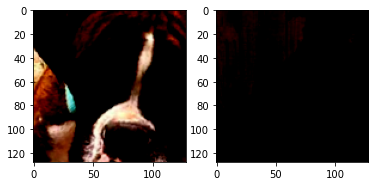

In [7]:
#Create training and testing image iterators to cycle through
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

#Print class and label information to understand data structure
print(train_data.classes)
print(train_labels)
print(test_labels)
print(train_images.shape)
print(test_images.shape)
print(train_images.view(train_images.shape[0], -1).shape)
print(test_images.view(test_images.shape[0], -1).shape)

#Plot an example image from test set and training set
plt.subplot(1, 2, 1)
plt.imshow(train_images[0].numpy().transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(test_images[0].numpy().transpose((1, 2, 0)))

In [8]:
#Create a Classifier class, inheriting from nn.Module and incorporating Relu, Dropout and log_softmax
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_3d_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, len(train_data.classes))
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [17]:
#Create our model from our prepared classifier and define the loss criterion and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#Initialize testing loss history
training_loss_history, testing_loss_history = [], []
model

Classifier(
  (fc1): Linear(in_features=49152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [18]:
# Option to reload from previous state
checkpoint = torch.load('dog-cat-deep-learn-prototype.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [19]:
# Check model can successfully run 5 batches before running entire model, also great for watching performance
epochs = 5

for e in range(epochs):
    
    train_images, train_labels = next(iter(train_loader))
    test_images, test_labels = next(iter(test_loader))
        
    epoch_train_loss = 0 # initialize total training loss for this epoch
    optimizer.zero_grad() # clear gradient history
    log_out = model(train_images) # run image through model to get logarithmic probability
    loss = criterion(log_out, train_labels) # calculate loss (error) for this image batch based on criterion

    loss.backward() # backpropogate gradients through model based on error
    optimizer.step() # update weights in model based on calculated gradient information
    epoch_train_loss += loss.item() # add training loss to total train loss this epoch, convert to value with .item()

    epoch_test_loss = 0 # initialize total testing loss for this epoch
    test_count_correct = 0 # initialize total correct predictions on test set
    with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
        log_out = model(test_images) # obtain the logarithmic probability from the model
        loss = criterion(log_out, test_labels) # calculate loss (error) for this image batch based on criterion
        epoch_test_loss += loss.item() # add testing loss to total test loss this epoch, convert to value with .item()

        out = torch.exp(log_out) # obtain probability from the logarithmic probability calculated by the model
        highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greatest calculated probability
        equals = chosen_class.view(test_labels.shape) == test_labels # determine how many correct matches were made in this batch
        test_count_correct += equals.sum()  # add the count of correct matches this batch to the total running this epoch

        ave_training_loss = epoch_train_loss / len(train_loader) # determine average loss per batch of training images
        ave_testing_loss = epoch_test_loss / len(test_loader) # determine average loss per batch of testing images
        training_loss_history.append(ave_training_loss) # append ave training loss to history of training losses
        training_loss_history.append(ave_training_loss) # append ave testing loss to history of testing losses
        
    
    model.train()
    print('Epoch: {}/{}.. '.format(e+1, epochs),
        'Train Loss: {:.4f}.. '.format(ave_training_loss),
        'Test Loss: {:.4f}.. '.format(ave_testing_loss),
        '{:.0f} of {:.0f} Correct'.format(test_count_correct, len(test_labels)))

print(test_data.classes)
print(test_labels)
print(chosen_class.view(test_labels.shape))

Epoch: 1/5..  Train Loss: 0.0040..  Test Loss: 0.0023..  10 of 16 Correct
Epoch: 2/5..  Train Loss: 0.0042..  Test Loss: 0.0018..  9 of 16 Correct
Epoch: 3/5..  Train Loss: 0.0041..  Test Loss: 0.0017..  9 of 16 Correct
Epoch: 4/5..  Train Loss: 0.0044..  Test Loss: 0.0018..  10 of 16 Correct
Epoch: 5/5..  Train Loss: 0.0039..  Test Loss: 0.0020..  9 of 16 Correct
['cat', 'dog']
tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])


In [336]:
t0 = time.time()

epochs = 50

for e in range(epochs):
    epoch_train_loss = 0 # initialize total training loss for this epoch
    for images, labels in train_loader: # cycle through training data
        optimizer.zero_grad() # clear gradient history
        log_out = model(images) # run image through model to get logarithmic probability
        loss = criterion(log_out, labels) # calculate loss (error) for this image batch based on criterion

        loss.backward() # backpropogate gradients through model based on error
        optimizer.step() # update weights in model based on calculated gradient information
        epoch_train_loss += loss.item() # add training loss to total train loss this epoch, convert to value with .item()
        
    else:
        epoch_test_loss = 0 # initialize total testing loss for this epoch
        test_count_correct = 0 # initialize total correct predictions on test set
        with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
            for images, labels in test_loader: # cycle through testing data to observe performance
                log_out = model(images) # obtain the logarithmic probability from the model
                loss = criterion(log_out, labels) # calculate loss (error) for this image batch based on criterion
                epoch_test_loss += loss.item() # add testing loss to total test loss this epoch, convert to value with .item()

                out = torch.exp(log_out) # obtain probability from the logarithmic probability calculated by the model
                highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greatest calculated probability
                equals = chosen_class.view(labels.shape) == labels # determine how many correct matches were made in this batch
                test_count_correct += equals.sum()  # add the count of correct matches this batch to the total running this epoch

            ave_training_loss = epoch_train_loss / len(train_loader) # determine average loss per batch of training images
            ave_testing_loss = epoch_test_loss / len(test_loader) # determine average loss per batch of testing images
            training_loss_history.append(ave_training_loss) # append ave training loss to history of training losses
            training_loss_history.append(ave_training_loss) # append ave testing loss to history of testing losses

        model.train()
        print('Epoch: {}/{}.. '.format(e+1, epochs),
            'Training Loss: {:.3f}.. '.format(ave_training_loss),
            'Test Loss: {:.3f}.. '.format(ave_testing_loss),
            'Test Accuracy: {:.3f}'.format(test_count_correct / len(test_loader.dataset)))
        
t1 = time.time()

Epoch: 1/50..  Training Loss: 0.679..  Test Loss: 0.673..  Test Accuracy: 0.576
Epoch: 2/50..  Training Loss: 0.676..  Test Loss: 0.665..  Test Accuracy: 0.591
Epoch: 3/50..  Training Loss: 0.676..  Test Loss: 0.655..  Test Accuracy: 0.612
Epoch: 4/50..  Training Loss: 0.672..  Test Loss: 0.652..  Test Accuracy: 0.612
Epoch: 5/50..  Training Loss: 0.670..  Test Loss: 0.652..  Test Accuracy: 0.608
Epoch: 6/50..  Training Loss: 0.671..  Test Loss: 0.652..  Test Accuracy: 0.614
Epoch: 7/50..  Training Loss: 0.668..  Test Loss: 0.648..  Test Accuracy: 0.621
Epoch: 8/50..  Training Loss: 0.670..  Test Loss: 0.652..  Test Accuracy: 0.616
Epoch: 9/50..  Training Loss: 0.666..  Test Loss: 0.648..  Test Accuracy: 0.618
Epoch: 10/50..  Training Loss: 0.668..  Test Loss: 0.644..  Test Accuracy: 0.618
Epoch: 11/50..  Training Loss: 0.664..  Test Loss: 0.643..  Test Accuracy: 0.626
Epoch: 12/50..  Training Loss: 0.663..  Test Loss: 0.642..  Test Accuracy: 0.621
Epoch: 13/50..  Training Loss: 0.665.

In [424]:
print('Runtime - {:.0f} min'.format((t1 - t0)/60))
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.cuda.is_available())

Runtime - 183 min
1
0
NVIDIA GeForce GTX 1050
True


In [418]:
#Play with performance

game_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                 transforms.CenterCrop(image_size),
                                 transforms.ToTensor()])

game_data = datasets.ImageFolder(data_dir + '/test', transform=game_transform)

game_loader = torch.utils.data.DataLoader(game_data, batch_size=2, shuffle=True)

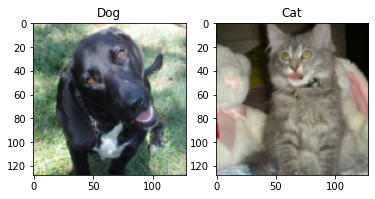

In [419]:
#Predicted images in batches of two!
game_images, game_labels = next(iter(game_loader))

prediction = torch.exp(model(game_images))
highest_prob, predicted_class = prediction.topk(1, dim=1)

plt.subplot(1, 2, 1)
if predicted_class[0] == 0:
    plt.title('Cat')
else:
    plt.title('Dog')
plt.imshow(game_images[0].numpy().transpose((1, 2, 0)))

plt.subplot(1, 2, 2)
if predicted_class[1] == 0:
    plt.title('Cat')
else:
    plt.title('Dog')
plt.imshow(game_images[1].numpy().transpose((1, 2, 0)))

In [363]:
torch.save(model.state_dict(), 'dog-cat-deep-learn-prototype.pth')
model.state_dict().keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])